In [3]:
%cd ../..

/home/jex/Documents/thesis/code/project


In [33]:
import torch
import mlflow
import re
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from src.shared.datasets.gbif.dataset import load_gbif_dataloader
from src.experiments.gbif_torch.models import LightningGBIF

In [34]:
HUGGING_FACE_FLAT_DATASET = "jkbkaiser/thesis-gbif-flat"
MLFLOW_EXPERIMENT = "gbif_torch"
MLFLOW_RUN_ID = "e00188b4b0b84863b16fc2198a9d6eb1"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [35]:
load_dotenv()
mlflow.set_experiment(MLFLOW_EXPERIMENT)

<Experiment: artifact_location='/home/jex/Documents/thesis/code/project/mlartifacts', creation_time=1736463864977, experiment_id='646620954956706749', last_update_time=1736463864977, lifecycle_stage='active', name='gbif_torch', tags={}>

In [36]:
def load_model_and_test_dataloader_from_mlflow_run(mlflow_run_id):
    query = f'attributes.run_id = "{mlflow_run_id}"'
    run = mlflow.search_runs(filter_string=query).iloc[0]
    artifact_uri = run["artifact_uri"]
    artifacts = mlflow.artifacts.list_artifacts(artifact_uri)
    highest_epoch_artifact = max(
        artifacts,
        key=lambda x: int(re.search(r"epoch=(\d+)", x.path).group(1))
    )
    artifact_name = highest_epoch_artifact.path.split('/')[1]
    checkpoint_path = f"{artifact_uri}/{artifact_name}/{artifact_name}.ckpt"
    
    model_name = run["params.model_name"]
    model_hparams = {
        "backbone_name": run["params.backbone_name"],
        "num_classes": int(run["params.num_classes"]),
        "freeze_backbone": True,
    }
    
    optim_name = run["params.optim_name"]
    optim_hparams = {}

    model = LightningGBIF.load_from_checkpoint(
        checkpoint_path,
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optim_name,
        optimizer_hparams=optim_hparams,
    )

    loader = load_gbif_dataloader("train", batch_size=16, version=run["params.dataset"], use_torch=True)

    return model, loader

model, loader = load_model_and_test_dataloader_from_mlflow_run(MLFLOW_RUN_ID)

loaded train split from jkbkaiser/thesis-gbif-flat dataset


In [37]:
first_batch = next(iter(loader))

In [43]:
imgs, genus_labels, species_labels = first_batch
logits = model(imgs.to(DEVICE))

In [52]:
multi_label = torch.zeros(logits.shape, device=genus_labels.device)
multi_label.scatter_(1, genus_labels.unsqueeze(1), 1)
multi_label.scatter_(1, species_labels.unsqueeze(1), 1)

multi_label = multi_label.to(DEVICE)

preds = (torch.sigmoid(logits) > 0.5).float()
print(preds.sum(dim=1))

genus_preds = preds[:, : 185]
species_preds = preds[:, 185 :]

acc_genus = (genus_preds == multi_label[:, : 185]).float().mean()
acc_species = (species_preds == multi_label[:, 185 :]).float().mean()
acc_total = (acc_genus + acc_species) / 2

print(acc_genus, acc_species, acc_total)

tensor([0., 0., 0., 2., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor(0.9929, device='cuda:0') tensor(0.9947, device='cuda:0') tensor(0.9938, device='cuda:0')


In [48]:
acc_genus = (genus_preds[0] == multi_label[0, : 185]).float().mean()

print(acc_genus)

tensor(0.9946, device='cuda:0')


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

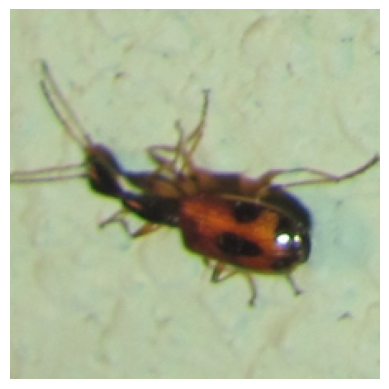

In [50]:
print(preds[1])

plt.imshow(imgs[0].transpose(0, 2))
plt.axis("off")
plt.show()